In [8]:
import json
import numpy as np
import random
import sys
from tqdm import tqdm
sys.path.append('../')
import utils

# fix random seed
np.random.seed(2023)
random.seed(2023)


def append_data_fix_drug(finetune_data, data, med_names, num_visits, \
    negative_ratio, drug_names=None, num_epochs=1):
    '''
    :param finetune_data: the finetune data
    :param data: the original data4LLM
    :param med_names: the list of all the drugs
    :param num_visits: the number of visits to be used, -1 means all the visits
    :param negative_ratio: the ratio of negative samples to positive samples, -1 means all the drugs
    :param med_weights: the weights of drugs
    :return: the finetune data
    target: fix the drug in the input
    '''
    data_len = len(finetune_data)
    prompter = utils.Prompter()
    if num_visits == -1:    # use all the data
        num_visits = len(data)
    pbar = tqdm()
    for epoch in range(num_epochs):
        for drug_name in drug_names:
            pos_num_visits = 0                   # the number of visits used
            for idx, row in data.iterrows():
                pos_med_list = eval(row['drug_name'])
                if drug_name not in pos_med_list:
                    continue
                pos_num_visits += 1
                pbar.update(1)
                if pos_num_visits > num_visits:
                    break
                input_text = prompter.generate_input(row, drug_candidate=drug_name)
                output = 'Yes.'
                json_item = {"input": input_text, "output": output}
                finetune_data.append(json_item)

                neg_num_visits = 0
                while neg_num_visits < negative_ratio:
                    # sample a visit
                    neg_visit_idx = random.randint(0, len(data)-1)
                    neg_visit = data.iloc[neg_visit_idx]
                    if drug_name in eval(neg_visit['drug_name']):
                        continue
                    neg_num_visits += 1
                    input_text = prompter.generate_input(neg_visit, drug_candidate=drug_name)
                    output = 'No.'
                    json_item = {"input": input_text, "output": output}
                    finetune_data.append(json_item)
        
    print(f'data appended: {len(finetune_data) - data_len}')
    return finetune_data


def get_data4finetune(num_visits, negative_ratio, output_filename, drug_names, num_epochs):
    '''
    :param data: the original data4LLM
    :param med_names: the list of all the drugs
    :param negative_ratio: the ratio of negative samples to positive samples
    :param num_samples: the number of samples to be generated
    :param output_filename: the output filename
    :return: the finetune data
    '''
    finetune_data = []

    data_train, med_names, med_weights = utils.load_data(mode='train')
    finetune_data = append_data_fix_drug(finetune_data, \
        data_train, med_names, num_visits, negative_ratio, drug_names, num_epochs)
    
    # val data
    data_val, med_names = utils.load_data(mode='val')
    finetune_data = append_data_fix_drug(finetune_data, \
        data_val, med_names, num_visits=100, negative_ratio=negative_ratio,\
        drug_names=drug_names, num_epochs=1)
    
    print(f'all finetune data generated: {len(finetune_data)}')
    with open(output_filename, 'w') as json_file:
        json.dump(finetune_data, json_file, indent=4)
        print(f'finetune data saved to {output_filename}\n\n')
    return finetune_data


# :param num_visits: the number of visits to be used, -1 means all the visits
# :param negative_ratio: the ratio of negative samples to positive samples, -1 means all the drugs

# num_visits = 100
num_visits = -1    # use all the visits
# drug_name = 'Metronidazole'
drug_names = ['Chlorhexidine', 'Metronidazole']
num_epochs = 10


for negative_ratio in [2]:
    print(f'----------------negative_ratio: {negative_ratio}----------------------')
    output_filename = f'../data/finetune_data_ratio_{negative_ratio}_{len(drug_names)}drugs_{num_epochs}epochs.json'
    # output_filename = '../data/finetune_data_test.json'
    data = get_data4finetune(num_visits, negative_ratio, output_filename, drug_names, num_epochs)

----------------negative_ratio: 2----------------------
Total number of drugs: 151
Train data size: 9960



4184it [00:02, 1699.25it/s]


data appended: 12552
Total number of drugs: 151
Val data size: 2490



202it [00:00, 1916.94it/s]

data appended: 600
all finetune data generated: 13152
finetune data saved to ../data/finetune_data_ratio_2_fix_2.json




In [11]:
(12552)*4

50208

In [4]:
data_train, med_names, med_weights = utils.load_data(mode='train')


Total number of drugs: 151
Train data size: 9960



In [6]:
med_names

['Acetaminophen',
 'Potassium chloride',
 'Pantoprazole',
 'Metoprolol',
 'Magnesium sulfate',
 'Furosemide',
 'Vancomycin',
 'Salbutamol',
 'Oxycodone',
 'Bisacodyl',
 'Lorazepam',
 'Magnesium',
 'Ipratropium',
 'Acetylsalicylic acid',
 'Morphine',
 'Ondansetron',
 'Fentanyl',
 'Calcium gluconate',
 'D-glucose',
 'Propofol',
 'Lansoprazole',
 'Hydromorphone',
 'Levofloxacin',
 'Atorvastatin',
 'Metronidazole',
 'Midazolam',
 'Lisinopril',
 'Warfarin',
 'Lidocaine',
 'Famotidine',
 'Hydralazine',
 'Chlorhexidine',
 'Phenylephrine',
 'Metoclopramide',
 'Ciprofloxacin',
 'Spironolactone',
 'Nitroglycerin',
 'Prednisone',
 'Sodium bicarbonate',
 'Tazobactam',
 'Diphenhydramine',
 'Omeprazole',
 'Lactulose',
 'Clopidogrel',
 'Zolpidem',
 'Fluticasone propionate',
 'Levothyroxine',
 'Norepinephrine',
 'Simvastatin',
 'Monopotassium phosphate',
 'Ranitidine',
 'Haloperidol',
 'Thiamine',
 'Cefazolin',
 'Piperacillin',
 'Amiodarone',
 'Ceftriaxone',
 'Trazodone',
 'Phylloquinone',
 'Miconazol

In [5]:
med_weights

[12264,
 10630,
 10099,
 9305,
 8804,
 8606,
 7904,
 6730,
 6652,
 6516,
 6119,
 5927,
 5460,
 5338,
 4835,
 4833,
 4635,
 4527,
 4121,
 4102,
 4073,
 4067,
 3964,
 3946,
 3933,
 3933,
 3510,
 3360,
 3344,
 3331,
 3202,
 3088,
 2938,
 2914,
 2892,
 2852,
 2756,
 2696,
 2686,
 2571,
 2516,
 2393,
 2386,
 2328,
 2301,
 2291,
 2277,
 2216,
 2197,
 2176,
 2165,
 2131,
 2124,
 2113,
 2107,
 2092,
 2081,
 2052,
 1995,
 1969,
 1821,
 1788,
 1771,
 1707,
 1680,
 1638,
 1627,
 1621,
 1608,
 1568,
 1564,
 1547,
 1530,
 1452,
 1444,
 1436,
 1430,
 1425,
 1401,
 1393,
 1369,
 1365,
 1336,
 1327,
 1309,
 1276,
 1275,
 1266,
 1246,
 1223,
 1208,
 1203,
 1202,
 1194,
 1180,
 1156,
 1155,
 1153,
 1118,
 1105,
 1103,
 1072,
 1071,
 1071,
 1067,
 1044,
 1021,
 1007,
 971,
 962,
 941,
 932,
 926,
 915,
 895,
 887,
 863,
 852,
 845,
 813,
 811,
 792,
 788,
 763,
 742,
 726,
 716,
 706,
 702,
 700,
 695,
 685,
 677,
 674,
 672,
 664,
 634,
 631,
 613,
 610,
 598,
 597,
 577,
 548,
 537,
 533,
 532,
 520,
 

In [17]:
data4LLM

,SUBJECT_ID,HADM_ID,diagnose,procedure,drug_name,drugbank_id_num,GENDER,AGE
0,17,161087,"['Pericardial disease NOS', 'Pleural effusion ...","['Venous cath NEC', 'Dx ultrasound-heart', 'Pe...","['Glycopyrronium', 'Neostigmine', 'Calcium glu...",338,female,48
1,17,194023,"['Secundum atrial sept def', 'Iatrogenc hypotn...","['Dx ultrasound-heart', 'Extracorporeal circul...","['Glycopyrronium', 'Neostigmine', 'Calcium glu...",358,female,47
2,21,109451,"['Subendo infarct, initial', 'Cardiogenic shoc...","['Packed cell transfusion', 'Pulsation balloon...","['Calcium gluconate', 'Magnesium sulfate', 'Fu...",489,male,87
3,21,111970,"['Septicemia NEC', 'Septic shock', 'Hyp kid NO...","['Hemodialysis', 'Arterial pressure monit', 'I...","['Magnesium sulfate', 'Acetaminophen', 'Potass...",325,male,88
4,23,124321,"['Ben neo cerebr meninges', 'Cerebral edema', ...",['Ex cereb meningeal les'],"['Magnesium sulfate', 'Acetaminophen', 'Potass...",327,male,75
...,...,...,...,...,...,...,...,...
14938,99923,164914,"['Iatrogenc hypotnsion NEC', 'Oth inf vena cav...","['Sm bowel endoscopy NEC', 'Percu abdominal dr...","['Acetaminophen', 'Warfarin', 'Ciprofloxacin',...",133,male,55
14939,99923,192053,"['Alcohol cirrhosis liver', 'End stage renal d...","['Kidney transplant NEC', 'Liver transplant NE...","['Calcium gluconate', 'Magnesium sulfate', 'Fu...",593,male,55
14940,99982,112748,"['Ac on chr syst hrt fail', 'Acute kidney fail...",['Rt heart cardiac cath'],"['Magnesium sulfate', 'Acetylsalicylic acid', ...",275,male,66
14941,99982,151454,"['Ac on chr syst hrt fail', 'Prim cardiomyopat...","['Extracorporeal circulat', 'Opn/oth rep tcspd...","['Glycopyrronium', 'Neostigmine', 'Magnesium s...",466,male,65


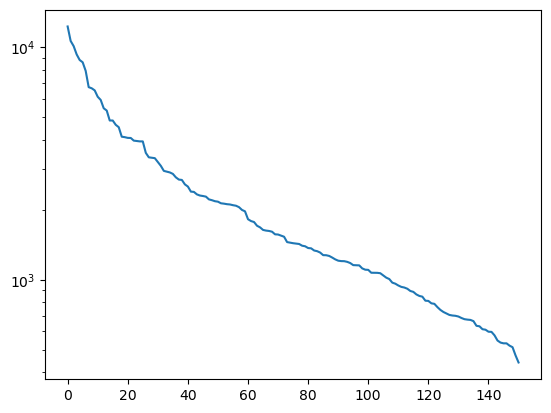

: 

In [6]:
import pandas as pd
import dill

data4LLM = pd.read_csv('../data/mimic-iii/data4LLM.csv')

# 设置列标题为['drug_id', 'drug_freq']
medicine_pop = pd.read_csv('../data/mimic-iii/medicine_pop.csv', names=['drug_id', 'drug_freq'])

# plot the distribution of the number of drugs
import matplotlib.pyplot as plt

plt.plot(medicine_pop['drug_freq'].values)
plt.yscale('log')

In [20]:
medicine_pop.iloc[200]

drug_id      224
drug_freq    281
Name: 200, dtype: int64

In [27]:
voc = dill.load(open('../data/mimic-iii/voc_final.pkl', 'rb'))
voc['med_voc'].idx2word[224]

'DB00684'

In [5]:
# 计算instruction的平均单词数
instruction_len = []
for item in data:
    instruction_len.append(len(item['input'].split()))
print('instruction average length: {}'.format(np.mean(instruction_len)))


instruction average length: 68.41432346723045


In [6]:
# 计算output为Yes的比例
output_yes = 0
for item in data:
    if item['output'] == 'Yes.':
        output_yes += 1
print('output Yes ratio: {}'.format(output_yes / len(data)))

output Yes ratio: 0.2
